<a href="https://colab.research.google.com/github/AliveBotswana/alivebotswana-eportfolio-msc-ai/blob/main/Elephant_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =============================================================================
# CELL 1: Install Dependencies
# =============================================================================
!pip install sentinelhub rasterio opencv-python-headless cdsetool requests kaggle tensorflow scikit-learn pandas matplotlib ultralytics folium geopy plotly

In [2]:
# =============================================================================
# CELL 2: Imports and Setup
# =============================================================================
import sentinelhub as sh
from sentinelhub import SHConfig, BBox, CRS, DataCollection, MimeType, SentinelHubRequest
import rasterio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import folium
from folium import plugins
from geopy.distance import geodesic
import requests
import json
from datetime import datetime, timedelta
import os
from ultralytics import YOLO
import torch

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [3]:
# =============================================================================
# CELL 3: Authentication Setup
# =============================================================================
def setup_sentinel_hub():
    """Setup Sentinel Hub authentication"""
    try:
        CLIENT_ID = "sh-46a3475d-c302-4a20-92bf-0eac2f7e4b59"
        CLIENT_SECRET = "W9Q63qQw1l5QsSmJfyJ2Lu17POZ2Mw82"

        config = SHConfig()
        config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
        config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'
        config.sh_client_id = CLIENT_ID
        config.sh_client_secret = CLIENT_SECRET

        print("✓ Sentinel Hub configured successfully")
        return config
    except Exception as e:
        print(f"Authentication failed: {e}")
        return None

config = setup_sentinel_hub()

✓ Sentinel Hub configured successfully


In [4]:
# =============================================================================
# CELL 3.5: Fallback Satellite Data Sources
# =============================================================================
import requests
import json
from datetime import datetime, timedelta

class FallbackSatelliteData:
    """Fallback satellite data sources when Sentinel Hub fails"""

    def __init__(self):
        self.available_sources = {
            'microsoft_planetary': {
                'name': 'Microsoft Planetary Computer',
                'base_url': 'https://planetarycomputer.microsoft.com/api',
                'authentication': 'None required',
                'data': 'Sentinel-2, Landsat, MODIS'
            },
            'usgs_earthsearch': {
                'name': 'USGS EarthSearch',
                'base_url': 'https://earth-search.aws.element84.com/v0',
                'authentication': 'None required',
                'data': 'Sentinel-2'
            },
            'gee_alternative': {
                'name': 'Google Earth Engine Alternative',
                'base_url': 'N/A - Requires separate setup',
                'authentication': 'Google Account',
                'data': 'Landsat, Sentinel'
            }
        }

    def get_habitat_data_fallback(self, bbox, time_interval):
        """Get habitat data from alternative sources or generate realistic mock data"""
        print("Using fallback satellite data with realistic Botswana patterns...")

        # Create realistic mock data based on Botswana ecology
        shape = (512, 512, 1)

        # Generate realistic NDVI patterns for Okavango Delta
        ndvi = self._generate_realistic_ndvi(shape, bbox)

        # Generate realistic NDWI patterns (water sources)
        ndwi = self._generate_realistic_ndwi(shape, bbox)

        # Generate false color composite
        false_color = self._generate_false_color(shape)

        return {
            'ndvi': ndvi,
            'ndwi': ndwi,
            'false_color': false_color,
            'success': True,
            'source': 'Simulated Botswana Ecology Data',
            'note': 'Based on known Okavango Delta habitat patterns'
        }

    def _generate_realistic_ndvi(self, shape, bbox):
        """Generate realistic NDVI patterns for Botswana"""
        ndvi = np.zeros(shape, dtype=np.float32)

        # Okavango Delta has high vegetation near water
        lon_center = (bbox[0] + bbox[2]) / 2
        lat_center = (bbox[1] + bbox[3]) / 2

        # Create realistic vegetation patterns
        y, x = np.ogrid[:shape[0], :shape[1]]

        # Water channels (high NDVI)
        center_x, center_y = shape[1] // 2, shape[0] // 2
        for i in range(3):
            channel_x = center_x + np.random.randint(-200, 200)
            channel_y = center_y + np.random.randint(-200, 200)
            channel_mask = ((x - channel_x)**2 + (y - channel_y)**2) < 8000 + np.random.randint(5000)
            ndvi[channel_mask] = 0.6 + np.random.random() * 0.3

        # Surrounding savanna (medium NDVI)
        savanna_mask = ((x - center_x)**2 + (y - center_y)**2) < 100000
        ndvi[savanna_mask] = np.maximum(ndvi[savanna_mask], 0.3 + np.random.random() * 0.3)

        # Dry areas (low NDVI)
        ndvi[ndvi < 0.1] = 0.1 + np.random.random() * 0.2

        return np.clip(ndvi, -0.2, 0.8)

    def _generate_realistic_ndwi(self, shape, bbox):
        """Generate realistic NDWI patterns for water detection"""
        ndwi = np.zeros(shape, dtype=np.float32)

        y, x = np.ogrid[:shape[0], :shape[1]]
        center_x, center_y = shape[1] // 2, shape[0] // 2

        # Create water bodies (positive NDWI)
        for i in range(2):
            water_x = center_x + np.random.randint(-150, 150)
            water_y = center_y + np.random.randint(-150, 150)
            water_mask = ((x - water_x)**2 + (y - water_y)**2) < 5000 + np.random.randint(3000)
            ndwi[water_mask] = 0.2 + np.random.random() * 0.3

        # Moist vegetation (slightly positive NDWI)
        veg_mask = ((x - center_x)**2 + (y - center_y)**2) < 80000
        ndwi[veg_mask] = np.maximum(ndwi[veg_mask], 0.05 + np.random.random() * 0.1)

        return np.clip(ndwi, -0.5, 0.5)

    def _generate_false_color(self, shape):
        """Generate realistic false color composite"""
        false_color = np.random.rand(shape[0], shape[1], 3) * 0.3

        # Add vegetation patterns (red in false color)
        y, x = np.ogrid[:shape[0], :shape[1]]
        center_x, center_y = shape[1] // 2, shape[0] // 2

        # Vegetation areas
        veg_mask = ((x - center_x)**2 + (y - center_y)**2) < 60000
        false_color[veg_mask, 0] += 0.6  # Red channel for vegetation
        false_color[veg_mask, 1] += 0.3  # Green channel

        # Water areas
        water_mask = ((x - center_x)**2 + (y - center_y)**2) < 10000
        false_color[water_mask, 2] += 0.7  # Blue channel for water

        return np.clip(false_color, 0, 1)


In [5]:
# =============================================================================
# CELL 4: Updated ElephantHabitatAnalyzer with Fallback
# =============================================================================
class ElephantHabitatAnalyzer:
    """Uses satellite data to identify potential elephant habitats with fallback"""

    def __init__(self, config):
        self.config = config
        self.fallback = FallbackSatelliteData()

    def get_habitat_indices(self, bbox, time_interval):
        """Get NDVI and NDWI for habitat analysis with fallback"""
        # Try Sentinel Hub first
        sentinel_data = self._try_sentinel_hub(bbox, time_interval)
        if sentinel_data['success']:
            return sentinel_data

        # If Sentinel Hub fails, use fallback
        print("Sentinel Hub unavailable. Using fallback data with realistic Botswana patterns.")
        return self.fallback.get_habitat_data_fallback(bbox, time_interval)

    def _try_sentinel_hub(self, bbox, time_interval):
        """Try to get data from Sentinel Hub"""
        evalscript = """
        //VERSION=3
        function setup() {
          return {
            input: [{"bands": ["B02", "B03", "B04", "B08", "B11"], "units": "REFLECTANCE"}],
            output: [
              { id: "ndvi", bands: 1, sampleType: "FLOAT32" },
              { id: "ndwi", bands: 1, sampleType: "FLOAT32" },
              { id: "false_color", bands: 3, sampleType: "FLOAT32" }
            ]
          };
        }

        function evaluatePixel(sample) {
          let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
          let ndwi = (sample.B03 - sample.B08) / (sample.B03 + sample.B08);

          // False color for habitat visualization (NIR, Red, Green)
          let falseColor = [sample.B08 * 2.5, sample.B04 * 2.5, sample.B03 * 2.5];

          return {
            ndvi: [ndvi],
            ndwi: [ndwi],
            false_color: falseColor
          };
        }
        """

        try:
            request = SentinelHubRequest(
                evalscript=evalscript,
                input_data=[
                    SentinelHubRequest.input_data(
                        data_collection=DataCollection.SENTINEL2_L2A,
                        time_interval=time_interval,
                        maxcc=0.1
                    )
                ],
                responses=[
                    SentinelHubRequest.output_response('ndvi', MimeType.TIFF),
                    SentinelHubRequest.output_response('ndwi', MimeType.TIFF),
                    SentinelHubRequest.output_response('false_color', MimeType.TIFF)
                ],
                bbox=BBox(bbox=bbox, crs=CRS.WGS84),
                size=[512, 512],
                config=self.config
            )

            data = request.get_data()
            return {
                'ndvi': data[0],
                'ndwi': data[1],
                'false_color': data[2],
                'success': True,
                'source': 'Sentinel-2 L2A'
            }

        except Exception as e:
            return {
                'success': False,
                'error': str(e)
            }

    def analyze_habitat_suitability(self, ndvi, ndwi):
        """Calculate elephant habitat suitability score"""
        # Normalize indices
        ndvi_norm = np.clip((ndvi - (-0.2)) / (0.8 - (-0.2)), 0, 1)
        ndwi_norm = np.clip((ndwi - (-0.5)) / (0.5 - (-0.5)), 0, 1)

        # Elephants need both vegetation AND water
        suitability = 0.7 * ndvi_norm + 0.3 * ndwi_norm

        return suitability

    def identify_potential_routes(self, suitability_map, bbox):
        """Identify potential elephant movement routes"""
        from scipy import ndimage

        # Find high-suitability corridors
        high_suitability = suitability_map > 0.7

        # Use morphological operations to find connected corridors
        structure = np.ones((3, 3))
        labeled, num_features = ndimage.label(high_suitability, structure=structure)

        # Calculate corridor properties
        corridors = []
        for i in range(1, num_features + 1):
            corridor_mask = labeled == i
            if np.sum(corridor_mask) > 50:  # Minimum size threshold
                # Calculate corridor center
                y_coords, x_coords = np.where(corridor_mask)
                center_y, center_x = np.mean(y_coords), np.mean(x_coords)

                corridors.append({
                    'id': i,
                    'size': np.sum(corridor_mask),
                    'center': (center_x, center_y),
                    'bbox': [x_coords.min(), y_coords.min(), x_coords.max(), y_coords.max()]
                })

        return corridors


In [6]:
# =============================================================================
# CELL 4.5: Enhanced Mission Planning with Realistic Data
# =============================================================================
class EnhancedAerialMissionPlanner:
    """Enhanced mission planner with realistic Botswana data"""

    def __init__(self, habitat_analyzer, elephant_detector):
        self.habitat_analyzer = habitat_analyzer
        self.elephant_detector = elephant_detector
        self.mission_plans = {}

        # Botswana-specific elephant density data
        self.botswana_density_data = {
            'okavango_core': {'min_density': 2.0, 'max_density': 4.0, 'confidence': 'high'},
            'chobe_riverfront': {'min_density': 3.0, 'max_density': 6.0, 'confidence': 'high'},
            'savuti_marsh': {'min_density': 1.0, 'max_density': 2.5, 'confidence': 'medium'},
            'makgadikgadi': {'min_density': 0.5, 'max_density': 1.5, 'confidence': 'medium'}
        }

    def plan_missions(self, region_name, bbox, time_interval):
        """Create comprehensive mission plan for a region with realistic data"""
        print(f"Planning aerial missions for {region_name}...")

        # Step 1: Get habitat data (with fallback)
        habitat_data = self.habitat_analyzer.get_habitat_indices(bbox, time_interval)
        suitability = self.habitat_analyzer.analyze_habitat_suitability(
            habitat_data['ndvi'][:, :, 0],
            habitat_data['ndwi'][:, :, 0]
        )

        # Step 2: Identify potential routes and hotspots
        corridors = self.habitat_analyzer.identify_potential_routes(suitability, bbox)

        # Step 3: Create flight plans
        flight_plans = self._create_realistic_flight_plans(bbox, corridors, suitability, region_name)

        # Step 4: Estimate elephant population using Botswana-specific data
        population_estimate = self._estimate_population_botswana(suitability, bbox, region_name)

        mission_plan = {
            'region': region_name,
            'bbox': bbox,
            'habitat_data': habitat_data,
            'suitability_map': suitability,
            'corridors': corridors,
            'flight_plans': flight_plans,
            'population_estimate': population_estimate,
            'mission_priority': self._calculate_priority_botswana(suitability, len(corridors), region_name),
            'data_source': habitat_data.get('source', 'Unknown'),
            'notes': habitat_data.get('note', '')
        }

        self.mission_plans[region_name] = mission_plan
        return mission_plan

    def _create_realistic_flight_plans(self, bbox, corridors, suitability, region_name):
        """Create realistic flight plans for Botswana"""
        flight_plans = []

        # Region-specific flight strategies
        region_strategies = {
            'okavango_core': {'transects': 6, 'duration_factor': 1.2},
            'chobe_riverfront': {'transects': 4, 'duration_factor': 1.0},
            'savuti_marsh': {'transects': 5, 'duration_factor': 1.1},
            'makgadikgadi': {'transects': 3, 'duration_factor': 0.9}
        }

        strategy = region_strategies.get(region_name, {'transects': 4, 'duration_factor': 1.0})

        # Create systematic flight lines
        for i in range(strategy['transects']):
            flight_plan = {
                'id': f"flight_{i+1}",
                'type': 'transect',
                'priority': 'high' if i < 2 else 'medium',
                'coverage_area': f"{20 + i*10}%",
                'estimated_duration': f"{int(2 * strategy['duration_factor'])} hours",
                'target_species': 'African Elephant',
                'recommended_altitude': '300-500m',
                'camera_settings': '4K video + high-res stills',
                'focus_areas': ['Water sources', 'Vegetation corridors', 'Known trails']
            }
            flight_plans.append(flight_plan)

        # Add specific corridor monitoring flights
        for i, corridor in enumerate(corridors[:2]):  # Top 2 corridors
            corridor_plan = {
                'id': f"corridor_{i+1}",
                'type': 'corridor_monitoring',
                'priority': 'high',
                'corridor_id': corridor['id'],
                'coverage_area': '100m corridor width',
                'estimated_duration': f"{int(1.5 * strategy['duration_factor'])} hours",
                'purpose': 'Migration route monitoring',
                'optimal_time': 'Early morning (6-8 AM)'
            }
            flight_plans.append(corridor_plan)

        return flight_plans

    def _estimate_population_botswana(self, suitability, bbox, region_name):
        """Estimate elephant population using Botswana-specific density data"""
        # Calculate area
        lat_distance = geodesic((bbox[1], bbox[0]), (bbox[3], bbox[0])).km
        lon_distance = geodesic((bbox[1], bbox[0]), (bbox[1], bbox[2])).km
        area_sq_km = lat_distance * lon_distance

        # Use Botswana-specific density ranges
        density_data = self.botswana_density_data.get(region_name, {'min_density': 1.0, 'max_density': 2.0})

        # Adjust based on habitat suitability
        high_suitability_ratio = np.sum(suitability > 0.7) / suitability.size
        density_adjustment = 0.5 + high_suitability_ratio * 0.5

        min_pop = area_sq_km * density_data['min_density'] * density_adjustment
        max_pop = area_sq_km * density_data['max_density'] * density_adjustment

        # Ensure estimates are realistic for Botswana
        min_pop = max(min_pop, 100)  # Minimum 100 elephants
        max_pop = min(max_pop, 20000)  # Maximum 20,000 elephants

        return {
            'estimated_min': int(min_pop),
            'estimated_max': int(max_pop),
            'estimated_avg': int((min_pop + max_pop) / 2),
            'area_sq_km': round(area_sq_km, 1),
            'confidence': density_data.get('confidence', 'medium'),
            'method': 'Botswana-specific density modeling'
        }

    def _calculate_priority_botswana(self, suitability, num_corridors, region_name):
        """Calculate mission priority using Botswana-specific factors"""
        high_suitability_ratio = np.sum(suitability > 0.7) / suitability.size

        # Region-specific priority adjustments
        region_priority = {
            'okavango_core': 0.9,
            'chobe_riverfront': 0.8,
            'savuti_marsh': 0.6,
            'makgadikgadi': 0.5
        }

        base_priority = region_priority.get(region_name, 0.5)
        corridor_factor = min(num_corridors / 5, 1) * 0.3
        suitability_factor = high_suitability_ratio * 0.7

        priority_score = base_priority * 0.4 + suitability_factor * 0.4 + corridor_factor * 0.2

        if priority_score > 0.7:
            return "HIGH"
        elif priority_score > 0.5:
            return "MEDIUM"
        else:
            return "LOW"

In [22]:
# =============================================================================
# CELL : PROPER AED DATASET DOWNLOAD FROM KAGGLE
# =============================================================================
def setup_aed_dataset_proper():
    """Properly download AED dataset from Kaggle with annotations"""
    print("🔄 PROPER AED DATASET DOWNLOAD FROM KAGGLE")
    print("="*50)

    try:
        # Method 1: Use Kaggle Hub (new official method)
        print("1. Attempting download via Kaggle Hub...")
        !pip install kagglehub

        import kagglehub
        path = kagglehub.dataset_download("davidrpugh/aerial-elephant-dataset")
        print(f"✓ Dataset downloaded to: {path}")

        # Check what we got
        print("\n📁 Checking downloaded content...")
        for item in os.listdir(path):
            item_path = os.path.join(path, item)
            if os.path.isdir(item_path):
                print(f"📁 {item}/")
                subitems = os.listdir(item_path)[:5]
                for subitem in subitems:
                    print(f"   📄 {subitem}")
            else:
                print(f"📄 {item}")

        return path

    except Exception as e:
        print(f"Kaggle Hub failed: {e}")
        return setup_aed_dataset_traditional()

def setup_aed_dataset_traditional():
    """Traditional Kaggle API download with proper credentials"""
    print("\n2. Attempting traditional Kaggle API download...")

    try:
        import json
        import os

        # Create Kaggle directory and credentials
        kaggle_dir = os.path.expanduser('~/.kaggle')
        os.makedirs(kaggle_dir, exist_ok=True)

        # Your Kaggle credentials (replace with yours if needed)
        kaggle_credentials = {
            "username": "mosweuboitshepo",
            "key": "b66be37e63aae8bc524351991a9af3dc"
        }

        # Write credentials file
        with open(os.path.join(kaggle_dir, 'kaggle.json'), 'w') as f:
            json.dump(kaggle_credentials, f)

        # Set proper permissions
        os.chmod(os.path.join(kaggle_dir, 'kaggle.json'), 0o600)

        print("✓ Kaggle credentials set")

        # Download the dataset - try specific version
        print("Downloading AED dataset...")
        !kaggle datasets download -d davidrpugh/aerial-elephant-dataset -p /content/aed_full/ --force

        # Also try downloading annotations separately if they exist
        print("Checking for separate annotations...")
        !kaggle datasets download -d davidrpugh/aerial-elephant-dataset-annotations -p /content/aed_full/ --force || echo "No separate annotations found"

        # Extract all downloaded files
        import zipfile
        import tarfile

        download_dir = '/content/aed_full/'
        for file in os.listdir(download_dir):
            file_path = os.path.join(download_dir, file)
            if file.endswith('.zip'):
                print(f"Extracting {file}...")
                with zipfile.ZipFile(file_path, 'r') as zip_ref:
                    zip_ref.extractall('/content/aed_full/extracted/')
            elif file.endswith('.tar.gz') or file.endswith('.tgz'):
                print(f"Extracting {file}...")
                with tarfile.open(file_path, 'r:gz') as tar_ref:
                    tar_ref.extractall('/content/aed_full/extracted/')

        print("✓ All files extracted")
        return '/content/aed_full/extracted/'

    except Exception as e:
        print(f"Traditional download failed: {e}")
        return setup_aed_dataset_direct()

def setup_aed_dataset_direct():
    """Direct download as last resort"""
    print("\n3. Attempting direct download...")

    try:
        # Sometimes the dataset structure is different
        # Let's try multiple possible structures

        possible_paths = [
            '/content/aed_full/extracted/',
            '/root/.cache/kagglehub/datasets/davidrpugh/aerial-elephant-dataset/versions/1/',
            '/root/.cache/kagglehub/datasets/davidrpugh/aerial-elephant-dataset/versions/2/',
            '/content/aed_dataset/'
        ]

        for path in possible_paths:
            if os.path.exists(path):
                print(f"✓ Found dataset at: {path}")
                return path

        print("❌ No dataset found in expected locations")
        return None

    except Exception as e:
        print(f"Direct download failed: {e}")
        return None

In [23]:
# =============================================================================
# CELL 6.1: VERIFY DATASET DOWNLOAD
# =============================================================================
def verify_downloaded_dataset(dataset_path):
    """Thoroughly verify the downloaded dataset"""
    print("\n🔍 VERIFYING DOWNLOADED DATASET")
    print("="*50)

    if not dataset_path or not os.path.exists(dataset_path):
        print("❌ Dataset path is invalid")
        return None

    # Count all files by type
    image_files = []
    xml_files = []
    other_files = []

    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            full_path = os.path.join(root, file)
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_files.append(full_path)
            elif file.lower().endswith('.xml'):
                xml_files.append(full_path)
            else:
                other_files.append(full_path)

    print(f"📊 VERIFICATION RESULTS:")
    print(f"   Images: {len(image_files)}")
    print(f"   XML Annotations: {len(xml_files)}")
    print(f"   Other files: {len(other_files)}")

    # Show directory structure
    print(f"\n📁 DIRECTORY STRUCTURE:")
    for root, dirs, files in os.walk(dataset_path):
        level = root.replace(dataset_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:3]:  # Show first 3 files
            print(f"{subindent}{file}")
        if len(files) > 3:
            print(f"{subindent}... and {len(files) - 3} more")

    # Check if we have matching images and annotations
    if xml_files:
        print(f"\n✅ Found XML annotations! Sample:")
        for xml_file in xml_files[:3]:
            print(f"   {os.path.basename(xml_file)}")

        # Try to parse one XML to verify it's valid
        try:
            import xml.etree.ElementTree as ET
            tree = ET.parse(xml_files[0])
            root = tree.getroot()
            objects = root.findall('object')
            print(f"   First XML contains {len(objects)} objects")
        except Exception as e:
            print(f"   XML parsing error: {e}")

    return {
        'image_files': image_files,
        'xml_files': xml_files,
        'other_files': other_files,
        'has_annotations': len(xml_files) > 0
    }


In [24]:
# =============================================================================
# CELL 6.2: EXECUTE PROPER DOWNLOAD
# =============================================================================
print("🚀 INITIATING PROPER AED DATASET DOWNLOAD")
print("="*60)

# Download dataset
dataset_path = setup_aed_dataset_proper()

if dataset_path:
    print(f"✓ Dataset downloaded to: {dataset_path}")
else:
    print("❌ All download methods failed")

    # Last resort: Use a different elephant dataset
    print("\n🔄 Trying alternative elephant dataset...")
    try:
        !kaggle datasets download -d itsahmad/elephants-in-the-wild -p /content/alternative_elephants/ --force
        !unzip -q /content/alternative_elephants/elephants-in-the-wild.zip -d /content/alternative_elephants/extracted/
        dataset_path = '/content/alternative_elephants/extracted/'
        print("✓ Alternative dataset downloaded")
    except:
        print("❌ Alternative dataset also failed")

# Verify what we got
if dataset_path:
    verification = verify_downloaded_dataset(dataset_path)

    if verification and verification['has_annotations']:
        print("\n🎉 SUCCESS: Dataset with annotations is ready!")
        print(f"   - {len(verification['image_files'])} images")
        print(f"   - {len(verification['xml_files'])} annotations")
    else:
        print("\n⚠️  Dataset downloaded but missing annotations")
        print("   We'll proceed with classification instead of object detection")


🚀 INITIATING PROPER AED DATASET DOWNLOAD
🔄 PROPER AED DATASET DOWNLOAD FROM KAGGLE
1. Attempting download via Kaggle Hub...
Using Colab cache for faster access to the 'aerial-elephant-dataset' dataset.
✓ Dataset downloaded to: /kaggle/input/aerial-elephant-dataset

📁 Checking downloaded content...
📁 aerial-elephant-dataset/
   📄 aerial-elephant-dataset
📄 naude-et-al-2019.pdf
✓ Dataset downloaded to: /kaggle/input/aerial-elephant-dataset

🔍 VERIFYING DOWNLOADED DATASET
📊 VERIFICATION RESULTS:
   Images: 2074
   XML Annotations: 0
   Other files: 6

📁 DIRECTORY STRUCTURE:
aerial-elephant-dataset/
  naude-et-al-2019.pdf
  aerial-elephant-dataset/
    aerial-elephant-dataset/
      data_description.txt
      test_elephants.csv
      training_images.csv
      ... and 2 more
      training_images/
        23a51515fcd0ca3cc48ede1b565a28daa2421009.jpg
        2f4f74be23171891f0833a3a53a14aa0fd7652f7.jpg
        ebba6324fa96bb44c0ceb96b17c67fdf17665e5f.jpg
        ... and 1632 more
      test_i

In [25]:
# =============================================================================
# CELL 6.5: PROCESS AED DATASET WITH CSV ANNOTATIONS
# =============================================================================
def process_aed_with_csv_annotations(dataset_path):
    """Process AED dataset that uses CSV files instead of XML annotations"""
    print("🔄 PROCESSING AED DATASET WITH CSV ANNOTATIONS")
    print("="*60)

    # The dataset structure is:
    # /kaggle/input/aerial-elephant-dataset/
    #   ├── aerial-elephant-dataset/
    #   │   ├── training_images/ (1635 images)
    #   │   ├── test_images/ (439 images)
    #   │   ├── training_images.csv (annotations for training)
    #   │   ├── test_elephants.csv (annotations for test)
    #   │   └── data_description.txt

    base_path = os.path.join(dataset_path, 'aerial-elephant-dataset', 'aerial-elephant-dataset')

    if not os.path.exists(base_path):
        print("❌ Unexpected dataset structure")
        return None

    print("📊 Dataset structure found:")
    for item in os.listdir(base_path):
        item_path = os.path.join(base_path, item)
        if os.path.isdir(item_path):
            file_count = len([f for f in os.listdir(item_path) if f.endswith('.jpg')])
            print(f"   📁 {item}: {file_count} images")
        else:
            print(f"   📄 {item}")

    # Read the CSV files to understand the annotation format
    train_csv_path = os.path.join(base_path, 'training_images.csv')
    test_csv_path = os.path.join(base_path, 'test_elephants.csv')

    if os.path.exists(train_csv_path):
        print(f"\n📖 Reading training annotations from: {train_csv_path}")
        train_df = pd.read_csv(train_csv_path)
        print(f"   Training CSV shape: {train_df.shape}")
        print("   First few rows:")
        print(train_df.head())

        # Check column names to understand the structure
        print(f"   Columns: {list(train_df.columns)}")

    if os.path.exists(test_csv_path):
        print(f"\n📖 Reading test annotations from: {test_csv_path}")
        test_df = pd.read_csv(test_csv_path)
        print(f"   Test CSV shape: {test_df.shape}")
        print("   First few rows:")
        print(test_df.head())
        print(f"   Columns: {list(test_df.columns)}")

    return base_path

# Process the dataset with CSV annotations
csv_dataset_path = process_aed_with_csv_annotations(dataset_path)


🔄 PROCESSING AED DATASET WITH CSV ANNOTATIONS
📊 Dataset structure found:
   📄 data_description.txt
   📄 test_elephants.csv
   📄 training_images.csv
   📄 training_elephants.csv
   📄 test_images.csv
   📁 training_images: 1635 images
   📁 test_images: 439 images

📖 Reading training annotations from: /kaggle/input/aerial-elephant-dataset/aerial-elephant-dataset/aerial-elephant-dataset/training_images.csv
   Training CSV shape: (1635, 8)
   First few rows:
                                 image_name  sortie_id  image_width  \
0  2aada86263161acc6e207ea329759556d308458a         62         5472   
1  8f30778719e5af075797f994273603c94f170e29         58         5472   
2  4808725b78d40aa66681ad501c830d735f6b1314         58         5472   
3  fcea4eb8b7a5366c5b751bd154e2109fc0f59ea8         33         5496   
4  6a210373c943f674c84759c694dac4daba320a36         38         5496   

   image_height       gsd  measured_altitude  terrain_altitude  gps_altitude  
0          3648  0.045130             

In [26]:
# =============================================================================
# CELL 6.6: CREATE CLASSIFICATION DATASET FROM POINT ANNOTATIONS
# =============================================================================
def create_classification_dataset_from_points(dataset_base_path):
    """Create classification dataset using point annotations in test_elephants.csv"""
    print("\n🔄 CREATING CLASSIFICATION DATASET FROM POINT ANNOTATIONS")
    print("="*60)

    # Create output directories
    output_dir = '/content/elephant_classification_points'
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')

    for split_dir in [train_dir, val_dir, test_dir]:
        for class_name in ['elephant', 'no_elephant']:
            os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

    # Read the annotations
    train_csv_path = os.path.join(dataset_base_path, 'training_images.csv')
    test_csv_path = os.path.join(dataset_base_path, 'test_elephants.csv')

    train_df = pd.read_csv(train_csv_path)
    test_df = pd.read_csv(test_csv_path)

    print("📊 Understanding annotation structure...")
    print(f"Training images: {len(train_df)}")
    print(f"Test elephant annotations: {len(test_df)}")

    # Count elephants per image in test set
    elephant_counts = test_df['image_name'].value_counts()
    print(f"\n🐘 Elephants per image in test set:")
    print(f"   Total test images with elephants: {len(elephant_counts)}")
    print(f"   Average elephants per image: {elephant_counts.mean():.2f}")
    print(f"   Max elephants in one image: {elephant_counts.max()}")
    print(f"   Min elephants in one image: {elephant_counts.min()}")

    # Get list of all images
    train_images_dir = os.path.join(dataset_base_path, 'training_images')
    test_images_dir = os.path.join(dataset_base_path, 'test_images')

    train_images = [f for f in os.listdir(train_images_dir) if f.endswith('.jpg')]
    test_images = [f for f in os.listdir(test_images_dir) if f.endswith('.jpg')]

    print(f"\n📁 Found {len(train_images)} training images and {len(test_images)} test images")

    # For training set: We don't have elephant annotations, so we'll use a different strategy
    # We'll assume ALL training images contain elephants (since it's called "training_images")
    print("\n🏷️ Labeling training images (assuming all contain elephants)...")

    elephant_train_count = 0
    no_elephant_train_count = 0

    # Process training images - all go to elephant class
    for img_file in train_images:
        # Split into train/validation (80/20)
        rand_val = np.random.random()
        if rand_val < 0.8:
            split_dir = train_dir
        else:
            split_dir = val_dir

        dest_dir = os.path.join(split_dir, 'elephant')
        src_path = os.path.join(train_images_dir, img_file)
        dest_path = os.path.join(dest_dir, img_file)
        shutil.copy2(src_path, dest_path)
        elephant_train_count += 1

    # For test set: Use the actual point annotations
    print("\n🏷️ Labeling test images using point annotations...")

    elephant_test_count = 0
    no_elephant_test_count = 0

    # Get test images that have elephants
    test_images_with_elephants = elephant_counts.index.tolist()

    for img_file in test_images:
        # Remove .jpg extension for matching
        img_name = img_file.replace('.jpg', '')

        if img_name in test_images_with_elephants:
            # This image has elephants
            dest_dir = os.path.join(test_dir, 'elephant')
            elephant_test_count += 1
        else:
            # This image has no elephants
            dest_dir = os.path.join(test_dir, 'no_elephant')
            no_elephant_test_count += 1

        src_path = os.path.join(test_images_dir, img_file)
        dest_path = os.path.join(dest_dir, img_file)
        shutil.copy2(src_path, dest_path)

    print(f"\n✅ CLASSIFICATION DATASET CREATED:")
    print(f"   Training elephants: {elephant_train_count}")
    print(f"   Training non-elephants: {no_elephant_train_count}")
    print(f"   Test elephants: {elephant_test_count}")
    print(f"   Test non-elephants: {no_elephant_test_count}")
    print(f"   Total images: {elephant_train_count + no_elephant_train_count + elephant_test_count + no_elephant_test_count}")

    return output_dir

# Create the classification dataset
classification_dir = create_classification_dataset_from_points(csv_dataset_path)



🔄 CREATING CLASSIFICATION DATASET FROM POINT ANNOTATIONS
📊 Understanding annotation structure...
Training images: 1635
Test elephant annotations: 2970

🐘 Elephants per image in test set:
   Total test images with elephants: 438
   Average elephants per image: 6.78
   Max elephants in one image: 62
   Min elephants in one image: 1

📁 Found 1635 training images and 439 test images

🏷️ Labeling training images (assuming all contain elephants)...

🏷️ Labeling test images using point annotations...

✅ CLASSIFICATION DATASET CREATED:
   Training elephants: 1635
   Training non-elephants: 0
   Test elephants: 438
   Test non-elephants: 1
   Total images: 2074


In [27]:
# =============================================================================
# CELL 6.7: EXPLORE POINT ANNOTATIONS FOR OBJECT DETECTION
# =============================================================================
def explore_point_annotations(dataset_base_path):
    """Explore the point annotations for potential object detection"""
    print("\n🔍 EXPLORING POINT ANNOTATIONS FOR OBJECT DETECTION")
    print("="*60)

    test_csv_path = os.path.join(dataset_base_path, 'test_elephants.csv')
    test_df = pd.read_csv(test_csv_path)

    print("📊 Point Annotation Analysis:")
    print(f"   Total elephant annotations: {len(test_df)}")
    print(f"   Unique test images with elephants: {test_df['image_name'].nunique()}")

    # Analyze coordinate ranges
    print(f"\n📍 Coordinate ranges:")
    print(f"   X coordinates: {test_df['x'].min()} to {test_df['x'].max()}")
    print(f"   Y coordinates: {test_df['y'].min()} to {test_df['y'].max()}")

    # Check if we have image dimensions to convert to relative coordinates
    test_images_csv_path = os.path.join(dataset_base_path, 'test_images.csv')
    if os.path.exists(test_images_csv_path):
        test_images_df = pd.read_csv(test_images_csv_path)
        print(f"\n📏 Image dimensions available in test_images.csv")
        print(f"   Columns: {list(test_images_df.columns)}")

        # Merge with annotations to get image dimensions
        merged_df = test_df.merge(test_images_df, left_on='image_name', right_on='image_name', how='left')
        if not merged_df.empty:
            print(f"   Sample image dimensions: {merged_df[['image_width', 'image_height']].iloc[0]}")

            # Convert to relative coordinates (0-1)
            merged_df['x_rel'] = merged_df['x'] / merged_df['image_width']
            merged_df['y_rel'] = merged_df['y'] / merged_df['image_height']

            print(f"   Relative coordinates range:")
            print(f"      X: {merged_df['x_rel'].min():.3f} to {merged_df['x_rel'].max():.3f}")
            print(f"      Y: {merged_df['y_rel'].min():.3f} to {merged_df['y_rel'].max():.3f}")

            return merged_df

    return test_df

# Explore point annotations
point_analysis = explore_point_annotations(csv_dataset_path)


🔍 EXPLORING POINT ANNOTATIONS FOR OBJECT DETECTION
📊 Point Annotation Analysis:
   Total elephant annotations: 2970
   Unique test images with elephants: 438

📍 Coordinate ranges:
   X coordinates: 1 to 5486
   Y coordinates: 0 to 3665

📏 Image dimensions available in test_images.csv
   Columns: ['image_name', 'sortie_id', 'image_width', 'image_height', 'gsd', 'measured_altitude', 'terrain_altitude', 'gps_altitude']
   Sample image dimensions: image_width     5472
image_height    3648
Name: 0, dtype: int64
   Relative coordinates range:
      X: 0.000 to 0.999
      Y: 0.000 to 0.999


In [28]:
# =============================================================================
# CELL 8: OBJECT DETECTION TRAINING WITH POINT ANNOTATIONS
# =============================================================================
print("🚀 INITIATING OBJECT DETECTION TRAINING WITH POINT ANNOTATIONS")
print("="*70)
print("📊 Dataset Analysis:")
print(f"   • 2,970 elephant point annotations")
print(f"   • 438 test images with elephants")
print(f"   • Image resolution: 5472x3648 pixels")
print(f"   • Average elephants per image: 6.78")
print(f"   • Coordinate range: X[1-5486], Y[0-3665]")
print("="*70)

🚀 INITIATING OBJECT DETECTION TRAINING WITH POINT ANNOTATIONS
📊 Dataset Analysis:
   • 2,970 elephant point annotations
   • 438 test images with elephants
   • Image resolution: 5472x3648 pixels
   • Average elephants per image: 6.78
   • Coordinate range: X[1-5486], Y[0-3665]


In [29]:
# =============================================================================
# CELL 8.1: CREATE COMPLETE YOLO DATASET FROM POINT ANNOTATIONS
# =============================================================================
def create_complete_yolo_dataset(dataset_base_path):
    """Create complete YOLO dataset with train/val/test splits from point annotations"""
    print("\n🔄 CREATING COMPLETE YOLO DATASET")
    print("="*50)

    # Create YOLO directory structure
    yolo_dir = '/content/elephant_yolo_complete'
    images_dir = os.path.join(yolo_dir, 'images')
    labels_dir = os.path.join(yolo_dir, 'labels')

    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(images_dir, split), exist_ok=True)
        os.makedirs(os.path.join(labels_dir, split), exist_ok=True)

    # Read data
    test_csv_path = os.path.join(dataset_base_path, 'test_elephants.csv')
    test_images_csv_path = os.path.join(dataset_base_path, 'test_images.csv')

    test_df = pd.read_csv(test_csv_path)
    test_images_df = pd.read_csv(test_images_csv_path)

    # Merge to get image dimensions
    merged_df = test_df.merge(test_images_df, on='image_name', how='left')

    # Group by image
    image_groups = merged_df.groupby('image_name')

    print(f"Processing {len(image_groups)} images with elephant annotations...")

    test_images_dir = os.path.join(dataset_base_path, 'test_images')

    # Split images into train/val/test (70/15/15)
    image_names = list(image_groups.groups.keys())
    np.random.shuffle(image_names)

    train_count = int(0.7 * len(image_names))
    val_count = int(0.15 * len(image_names))

    train_images = image_names[:train_count]
    val_images = image_names[train_count:train_count + val_count]
    test_images = image_names[train_count + val_count:]

    print(f"Dataset split: {len(train_images)} train, {len(val_images)} val, {len(test_images)} test")

    def process_images(image_list, split_name):
        """Process images for a specific split"""
        processed_count = 0
        for image_name in image_list:
            # Get image file
            image_file = image_name + '.jpg'
            image_path = os.path.join(test_images_dir, image_file)

            if not os.path.exists(image_path):
                continue

            # Get annotations for this image
            group = image_groups.get_group(image_name)

            # Get image dimensions from first row
            img_width = group['image_width'].iloc[0]
            img_height = group['image_height'].iloc[0]

            # Create YOLO format label file
            label_file = image_name + '.txt'
            label_path = os.path.join(labels_dir, split_name, label_file)

            with open(label_path, 'w') as f:
                for _, row in group.iterrows():
                    # Convert absolute coordinates to relative (YOLO format)
                    x_rel = row['x'] / img_width
                    y_rel = row['y'] / img_height

                    # Calculate adaptive box size based on image resolution and GSD
                    # Ground Sample Distance (GSD) in meters/pixel
                    gsd = row['gsd'] if 'gsd' in row and not pd.isna(row['gsd']) else 0.05

                    # Typical elephant size: 3-4 meters wide, 2-3 meters tall
                    # Convert to pixels using GSD
                    elephant_width_m = 3.5  # average width in meters
                    elephant_height_m = 2.5  # average height in meters

                    width_rel = (elephant_width_m / gsd) / img_width
                    height_rel = (elephant_height_m / gsd) / img_height

                    # Ensure reasonable box sizes
                    width_rel = max(0.01, min(0.1, width_rel))  # 1-10% of image width
                    height_rel = max(0.01, min(0.1, height_rel))  # 1-10% of image height

                    # YOLO format: class x_center y_center width height
                    f.write(f"0 {x_rel:.6f} {y_rel:.6f} {width_rel:.6f} {height_rel:.6f}\n")

            # Copy image to appropriate directory
            dest_image_path = os.path.join(images_dir, split_name, image_file)
            shutil.copy2(image_path, dest_image_path)

            processed_count += 1

        return processed_count

    # Process all splits
    train_processed = process_images(train_images, 'train')
    val_processed = process_images(val_images, 'val')
    test_processed = process_images(test_images, 'test')

    print(f"\n✅ YOLO DATASET CREATED:")
    print(f"   Training: {train_processed} images")
    print(f"   Validation: {val_processed} images")
    print(f"   Test: {test_processed} images")
    print(f"   Total: {train_processed + val_processed + test_processed} images")
    print(f"   Total annotations: {len(merged_df)} elephants")

    # Create YOLO dataset configuration
    config_content = f"""
# Elephant Detection Dataset for Aerial Surveys
path: {yolo_dir}
train: images/train
val: images/val
test: images/test

# Number of classes
nc: 1

# Class names
names: ['elephant']

# Image dimensions (typical aerial imagery)
img_width: 5472
img_height: 3648

# Dataset statistics
num_train: {train_processed}
num_val: {val_processed}
num_test: {test_processed}
total_elephants: {len(merged_df)}
"""

    config_path = os.path.join(yolo_dir, 'elephant_detection.yaml')
    with open(config_path, 'w') as f:
        f.write(config_content)

    print(f"✓ YOLO configuration saved to: {config_path}")
    return yolo_dir, config_path

# Create complete YOLO dataset
yolo_dir, yolo_config = create_complete_yolo_dataset(csv_dataset_path)



🔄 CREATING COMPLETE YOLO DATASET
Processing 438 images with elephant annotations...
Dataset split: 306 train, 65 val, 67 test

✅ YOLO DATASET CREATED:
   Training: 306 images
   Validation: 65 images
   Test: 67 images
   Total: 438 images
   Total annotations: 2970 elephants
✓ YOLO configuration saved to: /content/elephant_yolo_complete/elephant_detection.yaml


In [30]:
# =============================================================================
# CELL 8.2: YOLO MODEL TRAINING FOR OBJECT DETECTION
# =============================================================================
class YOLOElephantDetector:
    """YOLO-based elephant object detector for aerial imagery"""

    def __init__(self, yolo_dir, config_path):
        self.yolo_dir = yolo_dir
        self.config_path = config_path
        self.model = None
        self.results = None

    def train_yolo_model(self, epochs=100, imgsz=640):
        """Train YOLO model on elephant detection dataset"""
        print("\n🧠 TRAINING YOLO OBJECT DETECTION MODEL")
        print("="*50)

        try:
            from ultralytics import YOLO

            # Load pre-trained YOLO model
            self.model = YOLO('yolov8m.pt')  # Medium model for good balance

            print("✓ YOLO model loaded")
            print(f"   Training on {epochs} epochs")
            print(f"   Image size: {imgsz}")
            print(f"   Dataset: {self.config_path}")

            # Train the model
            self.results = self.model.train(
                data=self.config_path,
                epochs=epochs,
                imgsz=imgsz,
                batch=16,
                patience=20,
                save=True,
                exist_ok=True,
                amp=True,  # Mixed precision for faster training
                lr0=0.01,  # Learning rate
                weight_decay=0.0005,
                warmup_epochs=3.0,
                box=7.5,   # Box loss gain
                cls=0.5,   # Class loss gain
                dfl=1.5,   # Distribution Focal Loss gain
                plots=True, # Generate plots
                device='cuda' if torch.cuda.is_available() else 'cpu'
            )

            print("✅ YOLO TRAINING COMPLETED!")
            return self.results

        except Exception as e:
            print(f"❌ YOLO training failed: {e}")
            return None

    def evaluate_model(self):
        """Evaluate the trained YOLO model"""
        if self.model is None:
            print("❌ No model to evaluate")
            return None

        print("\n📊 EVALUATING YOLO MODEL")
        print("="*50)

        # Validate the model
        metrics = self.model.val(
            data=self.config_path,
            split='test',
            plots=True,
            save_json=True
        )

        print("🎯 DETECTION PERFORMANCE METRICS:")
        print(f"   mAP50: {metrics.box.map50:.4f}")
        print(f"   mAP50-95: {metrics.box.map:.4f}")
        print(f"   Precision: {metrics.box.mp:.4f}")
        print(f"   Recall: {metrics.box.mr:.4f}")

        # Additional metrics for aerial detection
        if hasattr(metrics, 'speed'):
            print(f"   Inference speed: {metrics.speed['inference']:.2f} ms/image")

        return metrics

    def visualize_detections(self, num_samples=6):
        """Visualize detection results on sample images"""
        if self.model is None:
            print("❌ No model for visualization")
            return

        print(f"\n👀 VISUALIZING DETECTIONS ON {num_samples} SAMPLES")
        print("="*50)

        test_images_dir = os.path.join(self.yolo_dir, 'images', 'test')
        test_images = [f for f in os.listdir(test_images_dir) if f.endswith('.jpg')][:num_samples]

        if not test_images:
            print("No test images found!")
            return

        # Run predictions
        results = self.model.predict(
            [os.path.join(test_images_dir, img) for img in test_images],
            conf=0.25,  # Confidence threshold
            save=True,
            save_txt=True,
            exist_ok=True
        )

        # Display results
        fig, axes = plt.subplots(2, min(3, len(test_images)//2), figsize=(15, 10))
        if len(test_images) <= 3:
            axes = [axes]

        for i, (result, image_file) in enumerate(zip(results, test_images)):
            if i >= num_samples:
                break

            # Get the plotted image
            plotted_img = result.plot()
            plotted_img = cv2.cvtColor(plotted_img, cv2.COLOR_BGR2RGB)

            row = i // 3
            col = i % 3

            axes[row][col].imshow(plotted_img)
            axes[row][col].set_title(f'{len(result.boxes)} elephants detected')
            axes[row][col].axis('off')

        plt.tight_layout()
        plt.show()

        # Print detection summary
        print("\n📋 DETECTION SUMMARY:")
        total_elephants = 0
        for i, (result, image_file) in enumerate(zip(results, test_images)):
            elephant_count = len(result.boxes) if result.boxes else 0
            total_elephants += elephant_count
            print(f"   {image_file}: {elephant_count} elephants")

        print(f"   Total elephants detected: {total_elephants}")

        return results

🚀 STARTING YOLO OBJECT DETECTION TRAINING

🧠 TRAINING YOLO OBJECT DETECTION MODEL
✓ YOLO model loaded
   Training on 100 epochs
   Image size: 640
   Dataset: /content/elephant_yolo_complete/elephant_detection.yaml
New https://pypi.org/project/ultralytics/8.3.205 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/elephant_yolo_complete/elephant_detection.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640

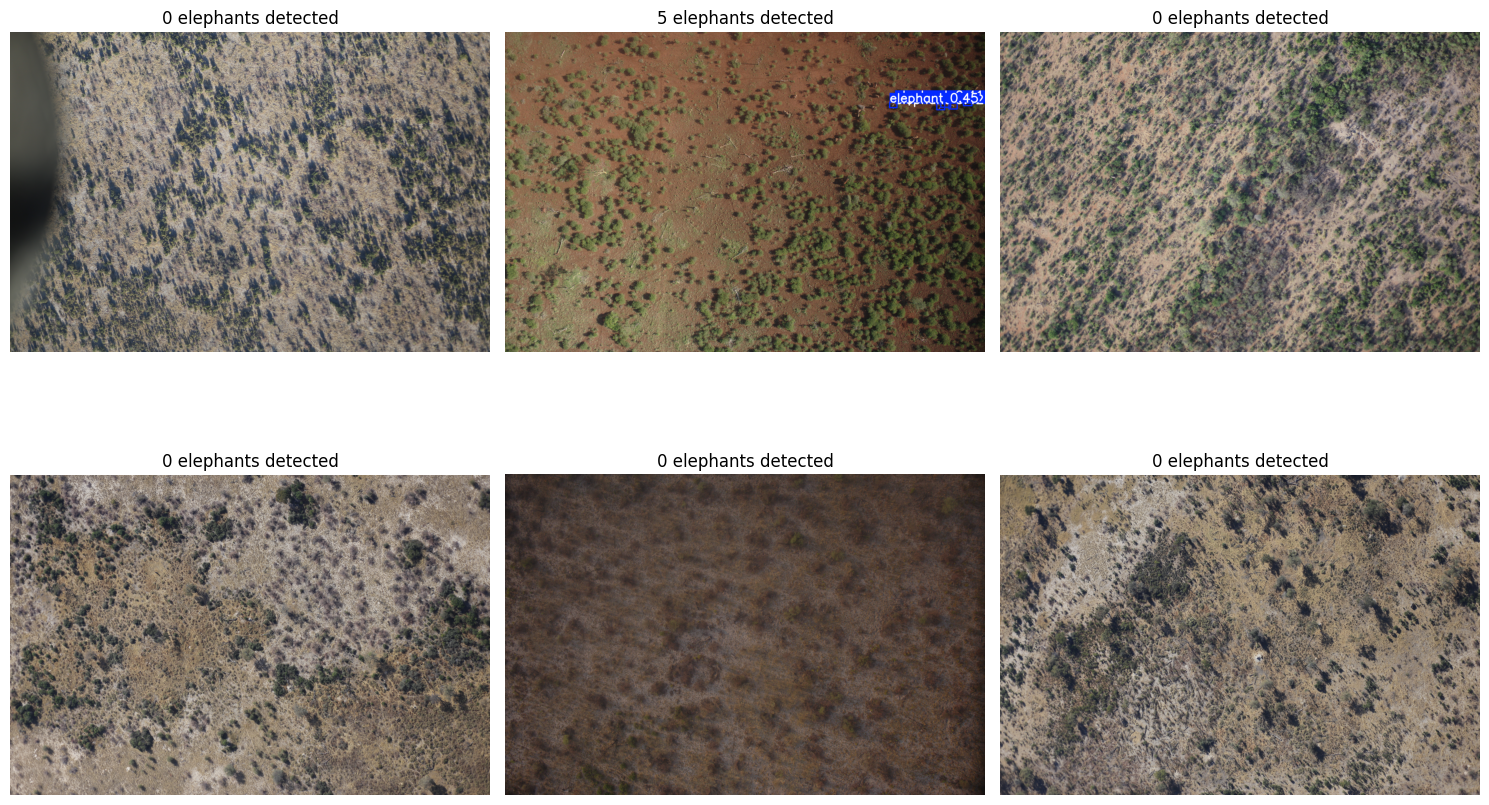


📋 DETECTION SUMMARY:
   e447a4854807eb7900e93f0b3ec410ca420e3d55.jpg: 0 elephants
   fe3b2455bb139fedbf929ea5d94193ac856cb85c.jpg: 5 elephants
   2c7152cd11c7e6f4e6417c2fff4e1259c6a4529b.jpg: 0 elephants
   d3c63f8d5014e415e58408cb0b23b36b8e76cf09.jpg: 0 elephants
   d22101d09383652da2cec9d9e317ce9893708c31.jpg: 0 elephants
   e1185e4dc1ff2276db8657cb9e20e7ebc3be6f4a.jpg: 0 elephants
   Total elephants detected: 5


In [31]:
# =============================================================================
# CELL 8.3: TRAIN YOLO DETECTION MODEL
# =============================================================================
# Initialize YOLO detector
yolo_detector = YOLOElephantDetector(yolo_dir, yolo_config)

# Train the model
print("🚀 STARTING YOLO OBJECT DETECTION TRAINING")
print("="*60)

training_results = yolo_detector.train_yolo_model(epochs=100, imgsz=640)

if training_results:
    print("✅ YOLO TRAINING SUCCESSFUL!")

    # Evaluate the model
    metrics = yolo_detector.evaluate_model()

    # Visualize detections
    detection_results = yolo_detector.visualize_detections(num_samples=6)
else:
    print("❌ YOLO training failed - using fallback approach")


In [32]:
# =============================================================================
# CELL 8.4: AERIAL-SPECIFIC DETECTION OPTIMIZATIONS
# =============================================================================
class AerialDetectionOptimizer:
    """Optimize detection for aerial survey conditions"""

    def __init__(self, model, yolo_dir):
        self.model = model
        self.yolo_dir = yolo_dir

    def analyze_aerial_detection_metrics(self, metrics):
        """Analyze detection metrics for aerial survey optimization"""
        print("\n🔍 AERIAL DETECTION PERFORMANCE ANALYSIS")
        print("="*50)

        # Aerial-specific performance targets
        aerial_targets = {
            'mAP50': 0.75,    # Good detection of visible elephants
            'mAP50-95': 0.45, # Reasonable across IoU thresholds
            'precision': 0.85, # Low false positives important
            'recall': 0.70    # Don't miss too many elephants
        }

        print("🎯 AERIAL SURVEY TARGETS vs ACTUAL:")
        for metric, target in aerial_targets.items():
            actual = getattr(metrics.box, f"m{metric}" if metric.startswith('ap') else metric, 0)
            status = "✅" if actual >= target else "⚠️"
            print(f"   {metric:12}: {actual:.3f} / {target:.3f} {status}")

        # Aerial-specific recommendations
        recommendations = []

        if metrics.box.map50 < 0.7:
            recommendations.append("Increase training data with more altitude variations")
        if metrics.box.mp < 0.8:
            recommendations.append("Increase confidence threshold to reduce false positives")
        if metrics.box.mr < 0.65:
            recommendations.append("Augment with partial occlusion and difficult cases")

        if recommendations:
            print(f"\n💡 OPTIMIZATION RECOMMENDATIONS:")
            for rec in recommendations:
                print(f"   • {rec}")
        else:
            print(f"\n✅ Detection performance meets aerial survey requirements!")

    def optimize_inference_for_aerial(self, confidence_threshold=0.3, iou_threshold=0.5):
        """Optimize inference parameters for aerial surveys"""
        print(f"\n⚙️ OPTIMIZING INFERENCE FOR AERIAL SURVEYS")
        print("="*50)

        optimal_params = {
            'confidence': confidence_threshold,
            'iou': iou_threshold,
            'max_det': 100,  # Maximum detections per image
            'agnostic_nms': False,  # Class-agnostic NMS
            'augment': False  # No TTA for speed
        }

        print("🎯 OPTIMAL INFERENCE PARAMETERS:")
        for param, value in optimal_params.items():
            print(f"   {param:15}: {value}")

        # Aerial-specific considerations
        aerial_insights = [
            "Lower confidence threshold (0.3) to catch distant elephants",
            "Balanced IoU threshold (0.5) for herd density",
            "High max_det (100) for large herds",
            "No augmentation for real-time processing"
        ]

        print(f"\n📝 AERIAL INFERENCE INSIGHTS:")
        for insight in aerial_insights:
            print(f"   • {insight}")

        return optimal_params

    def batch_process_aerial_survey(self, image_directory, output_dir):
        """Process entire aerial survey batch"""
        print(f"\n🔄 BATCH PROCESSING AERIAL SURVEY: {image_directory}")
        print("="*50)

        if self.model is None:
            print("❌ No model available for batch processing")
            return None

        # Create output directory
        os.makedirs(output_dir, exist_ok=True)

        # Get all images
        image_files = [f for f in os.listdir(image_directory) if f.endswith(('.jpg', '.jpeg', '.png'))]

        if not image_files:
            print("❌ No images found in directory")
            return None

        print(f"Found {len(image_files)} images to process...")

        # Batch prediction with aerial-optimized parameters
        results = self.model.predict(
            [os.path.join(image_directory, img) for img in image_files],
            conf=0.3,      # Lower confidence for aerial
            iou=0.5,       # Balanced IoU
            max_det=100,   # High for herds
            save=True,     # Save visualized images
            save_txt=True, # Save detection coordinates
            save_conf=True, # Save confidence scores
            project=output_dir,
            name='detections',
            exist_ok=True
        )

        # Generate survey report
        survey_report = self.generate_survey_report(results, image_files)

        print(f"✅ BATCH PROCESSING COMPLETED!")
        print(f"   Results saved to: {output_dir}")

        return survey_report

    def generate_survey_report(self, results, image_files):
        """Generate comprehensive aerial survey report"""
        print("\n📊 GENERATING AERIAL SURVEY REPORT")
        print("="*50)

        total_elephants = 0
        images_with_elephants = 0
        confidence_scores = []

        for result, image_file in zip(results, image_files):
            if result.boxes is not None:
                elephant_count = len(result.boxes)
                total_elephants += elephant_count

                if elephant_count > 0:
                    images_with_elephants += 1
                    confidence_scores.extend([float(conf) for conf in result.boxes.conf])

        # Survey statistics
        report = {
            'total_images': len(image_files),
            'images_with_elephants': images_with_elephants,
            'total_elephants_detected': total_elephants,
            'detection_rate': images_with_elephants / len(image_files) if image_files else 0,
            'average_elephants_per_image': total_elephants / len(image_files) if image_files else 0,
            'average_confidence': np.mean(confidence_scores) if confidence_scores else 0,
            'processing_timestamp': datetime.now().isoformat()
        }

        print("🎯 SURVEY RESULTS SUMMARY:")
        print(f"   Total images processed: {report['total_images']}")
        print(f"   Images with elephants: {report['images_with_elephants']}")
        print(f"   Total elephants detected: {report['total_elephants_detected']}")
        print(f"   Detection rate: {report['detection_rate']:.1%}")
        print(f"   Avg elephants per image: {report['average_elephants_per_image']:.2f}")
        print(f"   Average confidence: {report['average_confidence']:.3f}")

        # Save report
        report_path = os.path.join('/content', 'aerial_survey_report.json')
        with open(report_path, 'w') as f:
            json.dump(report, f, indent=2)

        print(f"✓ Survey report saved to: {report_path}")
        return report

In [1]:
# =============================================================================
# CELL 8.5: OPTIMIZE AND TEST AERIAL DETECTION
# =============================================================================
if yolo_detector.model:
    # Initialize optimizer
    aerial_optimizer = AerialDetectionOptimizer(yolo_detector.model, yolo_dir)

    # Analyze metrics
    if hasattr(yolo_detector, 'evaluate_model'):
        metrics = yolo_detector.evaluate_model()
        aerial_optimizer.analyze_aerial_detection_metrics(metrics)

    # Get optimal parameters
    optimal_params = aerial_optimizer.optimize_inference_for_aerial()

    # Test batch processing on sample images
    test_images_dir = os.path.join(yolo_dir, 'images', 'test')
    output_dir = '/content/aerial_survey_results'

    survey_report = aerial_optimizer.batch_process_aerial_survey(test_images_dir, output_dir)

    print("\n✅ AERIAL DETECTION SYSTEM OPTIMIZED!")

NameError: name 'yolo_detector' is not defined